<a href="https://www.kaggle.com/code/aisuko/super-resolution?scriptVersionId=164822184" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

Image-to-Image task is the task where an application receives an image and outputs another image. This has various subtasks, including:

- image enhancement,like(super resolution, low light enhancement, deraining etc.)
- imgae inpainting
- etc.

Here, we are going to use an image-to-image pipeline for super resolution task, and run image-to-image models for same task without a pipeline.

In [1]:
%%capture
!pip install transformers==4.35.2

In [2]:
from transformers import pipeline

pipe=pipeline(task="image-to-image", model="caidas/swin2SR-lightweight-x2-64", device="cuda")
print(pipe)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.18M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

(532, 432)


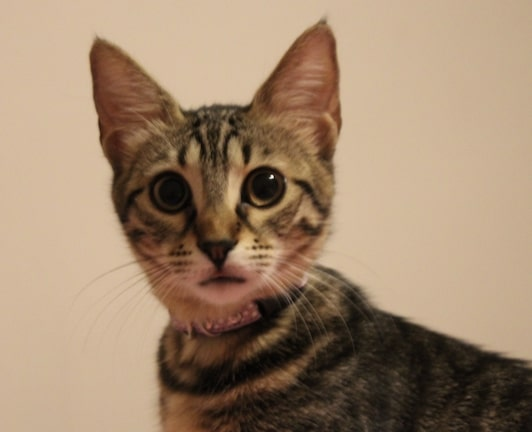

In [3]:
from PIL import Image
import requests

url="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/cat.jpg"
image=Image.open(requests.get(url, stream=True).raw)
print(image.size)

image

# Upscaled the Image

We can now do inference with the pipeline. We will get an upscaled version of the cat image.

(1072, 880)


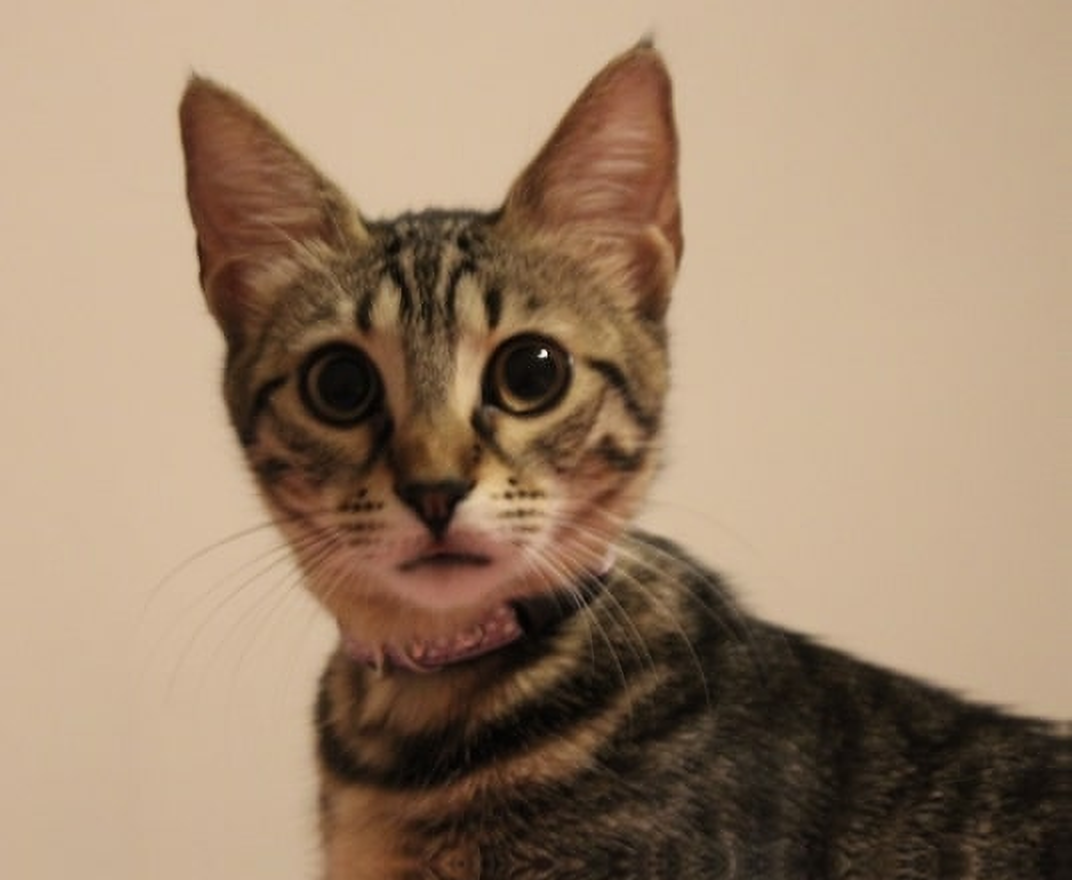

In [4]:
upscaled=pipe(image)
print(upscaled.size)

upscaled

# Without Pipeline

In [5]:
from transformers import Swin2SRForImageSuperResolution, Swin2SRImageProcessor

model=Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-lightweight-x2-64").to("cuda")
processor = Swin2SRImageProcessor("caidas/swin2SR-lightweight-x2-64")

Pipeline asbtracts away the preprocessing and postprocessing steps that we have to do ourselves. We will pass the image to the processor and then move the pixel values to GPU.

In [6]:
pixel_values=processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

pixel_values=pixel_values.to("cuda")

torch.Size([1, 3, 440, 536])


We can now infer the image by passing pixel values to the model.

In [7]:
import torch

with torch.no_grad():
    outputs=model(pixel_values)

outputs

ImageSuperResolutionOutput(loss=None, reconstruction=tensor([[[[0.8269, 0.8269, 0.8275,  ..., 0.7464, 0.7446, 0.7453],
          [0.8287, 0.8277, 0.8283,  ..., 0.7451, 0.7448, 0.7457],
          [0.8280, 0.8272, 0.8269,  ..., 0.7447, 0.7447, 0.7453],
          ...,
          [0.7923, 0.7924, 0.7918,  ..., 0.1048, 0.1046, 0.1060],
          [0.7927, 0.7926, 0.7931,  ..., 0.1028, 0.1038, 0.1062],
          [0.7937, 0.7917, 0.7929,  ..., 0.1019, 0.1057, 0.1082]],

         [[0.7256, 0.7246, 0.7256,  ..., 0.6521, 0.6512, 0.6523],
          [0.7261, 0.7253, 0.7258,  ..., 0.6513, 0.6506, 0.6514],
          [0.7260, 0.7253, 0.7252,  ..., 0.6515, 0.6505, 0.6505],
          ...,
          [0.6903, 0.6906, 0.6903,  ..., 0.0856, 0.0847, 0.0860],
          [0.6907, 0.6910, 0.6914,  ..., 0.0834, 0.0838, 0.0861],
          [0.6906, 0.6896, 0.6910,  ..., 0.0820, 0.0851, 0.0877]],

         [[0.6285, 0.6277, 0.6287,  ..., 0.5498, 0.5501, 0.5503],
          [0.6278, 0.6277, 0.6290,  ..., 0.5491, 0.5468

# Visualization the Image

We need to get the reconstruction and post-process it for visualization.

In [8]:
outputs.reconstruction.data.shape

torch.Size([1, 3, 880, 1072])

We need to squeeze the output and get rid of axis 0, clip the values, then convert it to be numpy float. Then we will arrange axes to have the shape [1072,880], and finally, bring the output back to range [0,255].

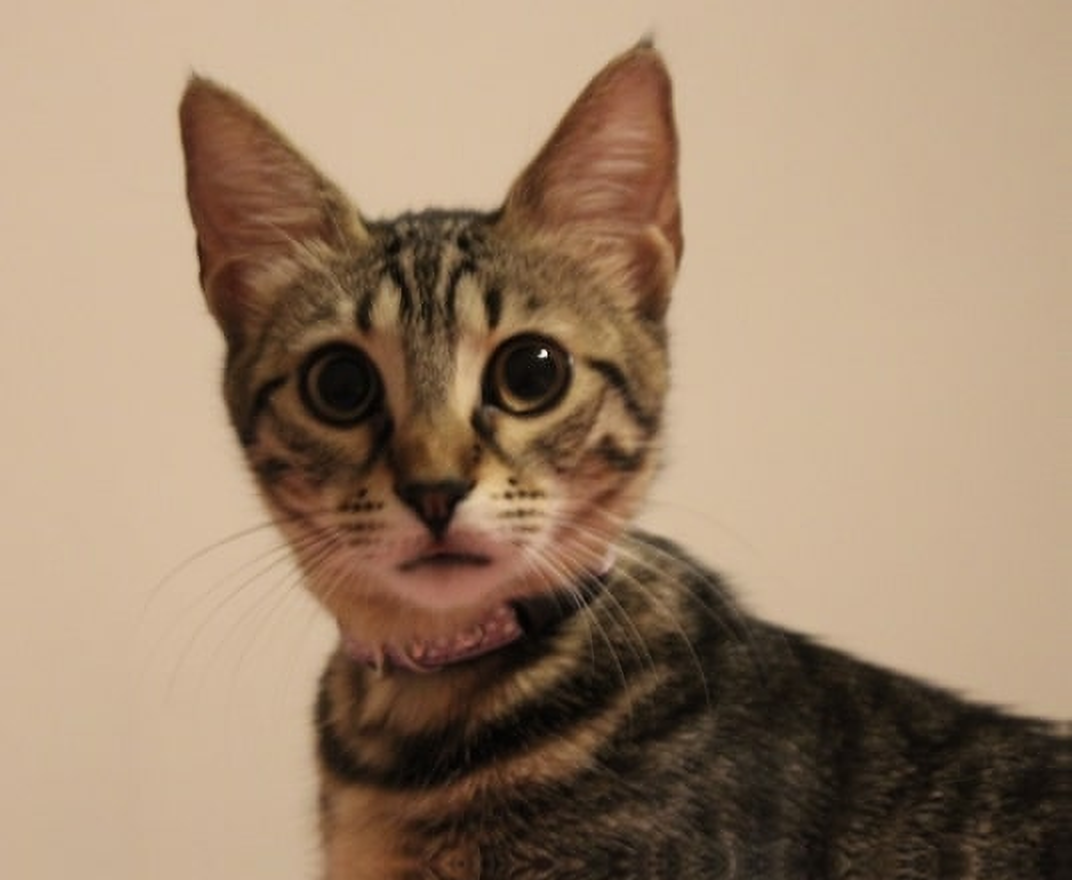

In [9]:
import numpy as np

# squeeze, take to CPU and clip the values
output=outputs.reconstruction.data.squeeze().cpu().clamp_(0,1).numpy()
# rearrange the axes
output=np.moveaxis(output, source=0, destination=-1)
# bring values back to pixel values range
output=(output*255.0).round().astype(np.uint8)
Image.fromarray(output)